# Exploration and Chart Development for Suspension Project Training Set

## 1. Load Packages

In [50]:
########## Load Packages
import warnings
warnings.simplefilter("ignore")

import importlib
import pandas as pd
import numpy as np
import re
from io import StringIO
import itertools
import os 
import time
import datetime

from io import StringIO # python3; python2: BytesIO 
import boto3

import random 
import math

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import seaborn as sns

import nltk 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel

import spacy
import fasttext

from hanziconv import HanziConv

import datetime as dt
import pytz

import langcodes
from langcodes import *
import language_data
from langdetect import detect

from snownlp import SnowNLP
import emoji
import cld3

In [51]:
path = 'simhei/SimHei.ttf'
fontprop = fm.FontProperties(fname=path, size=13)

## 2. Set parameters

In [52]:
# Set Parameters 
########## Set Parameters

# Indicate how many rows to skip before columns
# Note: Python uses zero-based indexing, so skiprow=0 begins at the first row of file,
# while skiprow=1 begins at the second row.
skiprow=0

# Indicate name of column that contains text data for analysis
text_column = "text"

import_bucket = "/Users/christian.conroy/OneDrive - Accenture Federal Services/Documents/StateGec/Brandwatch/Afghanistan/Results/"

results_bucket = '/Users/christian.conroy/OneDrive - Accenture Federal Services/Documents/StateGec/Brandwatch/Afghanistan/Results/eda/' # already created on S3

## 3. Load in Data

In [107]:
#### Load in data from S3

# Import Train and Measure Balance
# Import Flattened Data
df_train = pd.read_csv(import_bucket + "full_afghanistan_tweets.csv", error_bad_lines=False, encoding='utf-8')
len(df_train)

11796

In [108]:
print("full train:", len(df_train), "unique ids train:", len(df_train['user_id'].unique()))

full train: 11796 unique ids train: 7220


# 4. Create Outputs 

In [109]:
# Format dates 
df_train["account_created_at"] = pd.to_datetime(df_train["account_created_at"], format='%Y-%m-%d %H:%M:%S')
df_train["created_at"] = pd.to_datetime(df_train["created_at"], format='%Y-%m-%d %H:%M:%S')

# User Age (tweet created_at - account created_at)
df_train["user_age"] = (df_train["created_at"] - df_train["account_created_at"]).dt.days
df_train['tweets_per_day'] = df_train['statuses_count'].astype(float)/df_train["user_age"] 

#2009-05-03 07:35:47

In [110]:
# Calculate time since last tweet
df_train["since_last_tweet_mins"] = df_train.sort_values(['user_id','created_at']).groupby('user_id')['created_at'].diff().dt.seconds.div(60)
df_train = pd.merge(df_train, df_train.groupby(['user_id'], sort=False)['since_last_tweet_mins'].min().to_frame('since_last_tweet_mins_min'), on = ["user_id"])
df_train = pd.merge(df_train, df_train.groupby(['user_id'], sort=False)['since_last_tweet_mins'].max().to_frame('since_last_tweet_mins_max'), on = ["user_id"])
df_train = pd.merge(df_train, df_train.groupby(['user_id'], sort=False)['since_last_tweet_mins'].mean().to_frame('since_last_tweet_mins_mean'), on = ["user_id"])        

df_train['date'] = df_train['created_at'].dt.date
df_train['hour'] = df_train['created_at'].dt.hour
df_train = pd.merge(df_train, df_train[['user_id', 'date', 'hour', 'status_id']].groupby(['user_id', 'date', 'hour']).count().groupby('user_id', sort=False)["status_id"].mean().reset_index(name ='avg_tweets_per_hr'), on = ["user_id"])
df_train = pd.merge(df_train, df_train[['user_id', 'date', 'status_id']].groupby(['user_id', 'date']).count().groupby('user_id', sort=False)["status_id"].mean().reset_index(name ='avg_tweets_per_day'), on = ["user_id"])

In [111]:
df_train['no_hashtags'] = df_train['text'].apply(lambda x: len(re.findall(r"#(\w+)", x)))
df_train['no_mentions'] = df_train['text'].apply(lambda x: len(re.findall("@(\w{1,15})", x)))
df_train['no_urls'] = df_train['text'].apply(lambda x: len(re.findall("(?P<url>https?://[^\s]+)", x)))
df_train['tw_len'] = df_train['text'].apply(lambda x: len(x))
df_train['followers_per_followees'] = df_train['followers_count'].astype('float')/df_train['friends_count'].astype('float')

In [112]:
# URLs (percent of tweets with them)
df_train["containsURL"] = (df_train['no_urls']  > 0).astype(int)
url_counts = df_train.groupby('user_id').agg({'created_at':'count', 
                 'containsURL':'sum'})
url_counts['user.urls_per_tweet'] = url_counts['containsURL']/url_counts['created_at']
df_train = pd.merge(df_train, url_counts[['user.urls_per_tweet']], on = ["user_id"])  

# Hashtags, Mentions, and URLS
url_counts = df_train.groupby('user_id').agg({'created_at':'count', 
         'no_hashtags':'sum', 'no_mentions':'sum', 'no_urls':'sum'})
url_counts['no_hashtags_per_tweet'] = url_counts['no_hashtags']/url_counts['created_at']
url_counts['no_mentions_per_tweet'] = url_counts['no_mentions']/url_counts['created_at']
url_counts['no_urls_per_tweet'] = url_counts['no_urls']/url_counts['created_at']
df_train = pd.merge(df_train, url_counts[['no_hashtags_per_tweet', 'no_mentions_per_tweet', 'no_urls_per_tweet']], on = ["user_id"])  

df_train['followers_count'] = df_train['followers_count'].astype('float')
df_train['friends_count'] = df_train['friends_count'].astype('float')

In [113]:
# Pace of follower and friend add-on during collected time period 
avg_friends_per_day = df_train.groupby(['user_id', 'date'], as_index=True).mean()[['followers_count', 'friends_count']]
avg_friends_change = avg_friends_per_day.sort_values(['user_id','date']).groupby('user_id').diff().rename(columns={'followers_count':'followers_countdailychange','friends_count' : 'friends_countdailychange'})
df_train = pd.merge(df_train, avg_friends_change.groupby(['user_id'], as_index=True)[['followers_countdailychange', 'friends_countdailychange']].mean(), on = ["user_id"]) 

# Pace of follower and friend add-on overall 
df_train['user.friend_rate'] = df_train['friends_count']/df_train['user_age']
df_train['user.followers_rate'] = df_train['followers_count']/df_train['user_age']

df_train['user.has_url'] = (df_train['url'].fillna(False) != False).astype(int)
df_train['user.has_location'] = (df_train['location'].fillna(False) != False).astype(int)
df_train['user.screen_name.digit_length'] = df_train['screen_name'].apply(lambda x: len(re.sub("[^0-9]", "", x)) if pd.notnull(x) else x)
df_train['user.screen_name.length'] = df_train['screen_name'].apply(lambda x: len(x) if pd.notnull(x) else x)

In [114]:
# Convert emojis to words in bio 
df_train['user.description'] = df_train['description'].apply(lambda x: emoji.demojize(x, delimiters=("", " ")) if pd.notnull(x) else x)

# Convert emojis to words in name
df_train['user.name'] = df_train['name'].apply(lambda x: emoji.demojize(x, delimiters=("", " ")) if pd.notnull(x) else x)

## Create Account Level Dataset

In [115]:
pd.set_option('display.max_columns', None)
df_train.head(3)

,Unnamed: 0,user_id,status_id,created_at,screen_name,text,source,reply_to_screen_name,is_quote,is_retweet,favorite_count,retweet_count,hashtags,urls_url,urls_t.co,urls_expanded_url,media_url,media_t.co,media_expanded_url,media_type,ext_media_url,ext_media_t.co,ext_media_expanded_url,ext_media_type,mentions_user_id,mentions_screen_name,lang,quoted_user_id,quoted_screen_name,quoted_name,retweet_text,retweet_source,retweet_favorite_count,retweet_retweet_count,retweet_user_id,retweet_screen_name,retweet_name,retweet_followers_count,retweet_friends_count,retweet_statuses_count,retweet_location,retweet_description,retweet_verified,country,country_code,geo_coords,coords_coords,bbox_coords,status_url,name,location,description,url,protected,followers_count,friends_count,listed_count,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,filename,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,date,hour,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,followers_countdailychange,friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,user.description,user.name
0,1,37384635,1427130737959084032,2021-08-16 04:50:57,babsbear,Afghan girls on their way to school today morn...,Twitter for iPhone,NaN,False,True,0,2183,Kabul,NaN,NaN,NaN,http://pbs.twimg.com/media/E84Z4kgVIAAoWBN.jpg,https://t.co/GWHnLM5his,https://twitter.com/ahmermkhan/status/14271066...,photo,http://pbs.twimg.com/media/E84Z4kgVIAAoWBN.jpg,https://t.co/GWHnLM5his,https://twitter.com/ahmermkhan/status/14271066...,NaN,"c(""198017141"", ""69533216"")","c(""ahmermkhan"", ""jawidomid"")",en,NaN,NaN,NaN,Afghan girls on their way to school today morn...,Twitter for iPhone,10932.0,2183.0,198017141.0,ahmermkhan,Ahmer Khan,62508.0,1453.0,31090.0,South Asia,Award-winning & Emmy-nominated Multimedia Jour...,True,NaN,NaN,"c(NA, NA)","c(NA, NA)","c(NA, NA, NA, NA, NA, NA, NA, NA)",https://twitter.com/babsbear/status/1427130737...,Babs باربرا,NaN,Fight the odious debt inflicted on us - https:...,NaN,False,4475.0,4883.0,129,270805,192029,2009-05-03 07:35:47,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/37384635...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1333172342...,bw_api_pull_jaw,4487,60.353243,NaN,0.216667,0.816667,0.566667,2021-08-16,4,4.0,4.0,1,1,1,106,0.916445,1,1.0,1.0,0.25,1.0,NaN,NaN,1.088255,0.997326,0,0,0,8,Fight the odious debt inflicted on us - https:...,Babs باربرا
1,2,37384635,1427130959124738049,2021-08-16 04:51:50,babsbear,Emirates airline suspends flights to #Kabul: w...,Twitter for iPhone,NaN,False,True,0,13,Kabul,NaN,NaN,NaN,http://pbs.twimg.com/media/E84crnmWYAABFGY.jpg,https://t.co/GAxP2LXfpG,https://twitter.com/jawidomid/status/142710967...,photo,http://pbs.twimg.com/media/E84crnmWYAABFGY.jpg,https://t.co/GAxP2LXfpG,https://twitter.com/jawidomid/status/142710967...,NaN,69533216,jawidomid,en,NaN,NaN,NaN,Emirates airline suspends flights to #Kabul: w...,Twitter for iPhone,72.0,13.0,69533216.0,jawidomid,jawidomid,2854.0,355.0,2149.0,Afghanistan,"Journalist @XHNews, China Xinhua News/ based ...",False,NaN,NaN,"c(NA, NA)","c(NA, NA)","c(NA, NA, NA, NA, NA, NA, NA, NA)",https://twitter.com/babsbear/status/1427130959...,Babs باربرا,NaN,Fight the odious debt inflicted on us - https:...,NaN,False,4475.0,4883.0,129,270805,192029,2009-05-03 07:35:47,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/37384635...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1333172342...,bw_api_pull_jaw,4487,60.353243,0.216667,0.216667,0.816667,0.566667,2021-08-16,4,4.0,4.0,1,0,1,76,0.9

In [116]:
def epo_conv(epo):
    r = pd.to_datetime(epo, unit='s')
    return r

In [117]:
df_train['created_at'] = (df_train['created_at'] - dt.datetime(1970,1,1)).dt.total_seconds()
df_train['account_created_at'] = (df_train['account_created_at'] - dt.datetime(1970,1,1)).dt.total_seconds()

In [118]:
df_train_accounts = df_train.groupby(
   ['user_id', 'screen_name'], as_index=False
).agg(
    {
         'status_id': 'count',
         'created_at': 'mean',    
         'retweet_count': ['sum', 'mean'],  
         'favorite_count': ['sum', 'mean'],  
         'account_created_at': 'mean', 
         'favourites_count': ['mean', 'max'],  
         'followers_count': ['mean', 'max'], 
         'friends_count': ['mean', 'max'],  
         'listed_count': ['mean', 'max'],  
         'statuses_count': ['mean', 'max'],  
         'user_age': ['mean', 'max'],  
         'tweets_per_day': 'max',  
         'since_last_tweet_mins': ['min', 'mean', 'max'], 
         'avg_tweets_per_hr': 'mean',  
         'avg_tweets_per_day': 'mean',  
         'followers_per_followees': ['mean', 'min', 'max'],  
         'containsURL': 'sum',  
         'no_urls_per_tweet': 'mean', 
         'no_hashtags_per_tweet': 'mean',
         'no_mentions_per_tweet': 'mean',
         'followers_countdailychange': ['mean', 'max'], # Mean and max daily difference 
         'friends_countdailychange': ['mean', 'max'], # Mean and max daily difference 
         'user.friend_rate': ['mean', 'max'], # Friend count over age
         'user.followers_rate': ['mean', 'max'], # Follower count over age 
         'user.has_url': 'mean',
         'user.has_location': 'mean',
         'user.screen_name.digit_length': 'mean',
         'user.screen_name.length': 'mean',
    }
)

In [119]:
df_train_accounts.columns = df_train_accounts.columns.map('_'.join)
df_train_accounts.head(3)

,user_id_,screen_name_,status_id_count,created_at_mean,retweet_count_sum,retweet_count_mean,favorite_count_sum,favorite_count_mean,account_created_at_mean,favourites_count_mean,favourites_count_max,followers_count_mean,followers_count_max,friends_count_mean,friends_count_max,listed_count_mean,listed_count_max,statuses_count_mean,statuses_count_max,user_age_mean,user_age_max,tweets_per_day_max,since_last_tweet_mins_min,since_last_tweet_mins_mean,since_last_tweet_mins_max,avg_tweets_per_hr_mean,avg_tweets_per_day_mean,followers_per_followees_mean,followers_per_followees_min,followers_per_followees_max,containsURL_sum,no_urls_per_tweet_mean,no_hashtags_per_tweet_mean,no_mentions_per_tweet_mean,followers_countdailychange_mean,followers_countdailychange_max,friends_countdailychange_mean,friends_countdailychange_max,user.friend_rate_mean,user.friend_rate_max,user.followers_rate_mean,user.followers_rate_max,user.has_url_mean,user.has_location_mean,user.screen_name.digit_length_mean,user.screen_name.length_mean
0,59173,jorgebarahona,1,1.629049e+09,0,0.0,2,2.0,1.165892e+09,5463.0,5463,2843.0,2843.0,523.0,523.0,170,170,35873.0,35873,5360.0,5360,6.692724,NaN,NaN,NaN,1.0,1.0,5.435946,5.435946,5.435946,1,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.097575,0.097575,0.530410,0.530410,1,1,0,13
1,76183,SarahTitterton,1,1.628693e+09,23,23.0,0,0.0,1.166398e+09,2323.0,2323,2560.0,2560.0,1490.0,1490.0,88,88,9404.0,9404,5350.0,5350,1.757757,NaN,NaN,NaN,1.0,1.0,1.718121,1.718121,1.718121,1,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.278505,0.278505,0.478505,0.478505,1,0,0,14
2,798329,tansunit,1,1.629074e+09,62,62.0,0,0.0,1.172590e+09,5402.0,5402,7764.0,7764.0,1215.0,1215.0,135,135,50832.0,50832,5283.0,5283,9.621806,NaN,NaN,NaN,1.0,1.0,6.390123,6.390123,6.390123,1,1.0,2.0,1.0,NaN,NaN,NaN,NaN,0.229983,0.229983,1.469620,1.469620,1,1,0,8


In [120]:
df_train_accounts['created_at_mean'] = df_train_accounts['created_at_mean'].apply(lambda x: epo_conv(x))
df_train_accounts['account_created_at_mean'] = df_train_accounts['account_created_at_mean'].apply(lambda x: epo_conv(x))
df_train_accounts.head(3)

,user_id_,screen_name_,status_id_count,created_at_mean,retweet_count_sum,retweet_count_mean,favorite_count_sum,favorite_count_mean,account_created_at_mean,favourites_count_mean,favourites_count_max,followers_count_mean,followers_count_max,friends_count_mean,friends_count_max,listed_count_mean,listed_count_max,statuses_count_mean,statuses_count_max,user_age_mean,user_age_max,tweets_per_day_max,since_last_tweet_mins_min,since_last_tweet_mins_mean,since_last_tweet_mins_max,avg_tweets_per_hr_mean,avg_tweets_per_day_mean,followers_per_followees_mean,followers_per_followees_min,followers_per_followees_max,containsURL_sum,no_urls_per_tweet_mean,no_hashtags_per_tweet_mean,no_mentions_per_tweet_mean,followers_countdailychange_mean,followers_countdailychange_max,friends_countdailychange_mean,friends_countdailychange_max,user.friend_rate_mean,user.friend_rate_max,user.followers_rate_mean,user.followers_rate_max,user.has_url_mean,user.has_location_mean,user.screen_name.digit_length_mean,user.screen_name.length_mean
0,59173,jorgebarahona,1,2021-08-15 17:32:05,0,0.0,2,2.0,2006-12-12 02:58:49,5463.0,5463,2843.0,2843.0,523.0,523.0,170,170,35873.0,35873,5360.0,5360,6.692724,NaN,NaN,NaN,1.0,1.0,5.435946,5.435946,5.435946,1,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.097575,0.097575,0.530410,0.530410,1,1,0,13
1,76183,SarahTitterton,1,2021-08-11 14:40:37,23,23.0,0,0.0,2006-12-17 23:29:14,2323.0,2323,2560.0,2560.0,1490.0,1490.0,88,88,9404.0,9404,5350.0,5350,1.757757,NaN,NaN,NaN,1.0,1.0,1.718121,1.718121,1.718121,1,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.278505,0.278505,0.478505,0.478505,1,0,0,14
2,798329,tansunit,1,2021-08-16 00:31:32,62,62.0,0,0.0,2007-02-27 15:24:31,5402.0,5402,7764.0,7764.0,1215.0,1215.0,135,135,50832.0,50832,5283.0,5283,9.621806,NaN,NaN,NaN,1.0,1.0,6.390123,6.390123,6.390123,1,1.0,2.0,1.0,NaN,NaN,NaN,NaN,0.229983,0.229983,1.469620,1.469620,1,1,0,8


In [146]:
df_train_accounts['full_collapse'] = 1

## Creation date/duration

#### Account 

In [122]:
df_train_accounts['user.created_at_dmy'] = df_train_accounts['account_created_at_mean'].apply(lambda x:datetime.datetime.strftime(x, '%b %d %Y')).tolist()

In [125]:
P = df_train_accounts.groupby(['user.created_at_dmy'], as_index=False).agg({"user_id_": "count"})
P = P.rename(columns = {'user.created_at_dmy':'Date', 'user_id_':'Count'})
P['Date'] = pd.to_datetime(P['Date'], infer_datetime_format=True).dt.date
P = P.sort_values(by=['Count'], ascending = False)
P.head()

,Date,Count
201,2021-04-20,15
331,2021-08-04,15
1976,2021-06-27,14
393,2021-08-11,13
1641,2021-07-26,12


# Duration of existence for accounts 

In [131]:
P = df_train_accounts.groupby(['user_age_max'], as_index=False).agg({"user_id_": "count"})
P = P.rename(columns = {'user_age_max':'Duration of Existence','user_id_':'Count'})
P = P.sort_values(by=['Count'], ascending = False)
P.head(10)

,Duration of Existence,Count
0,0,20
3,3,14
5,5,14
22,22,13
1,1,12
6,6,12
173,174,12
31,31,12
2,2,11
69,69,11


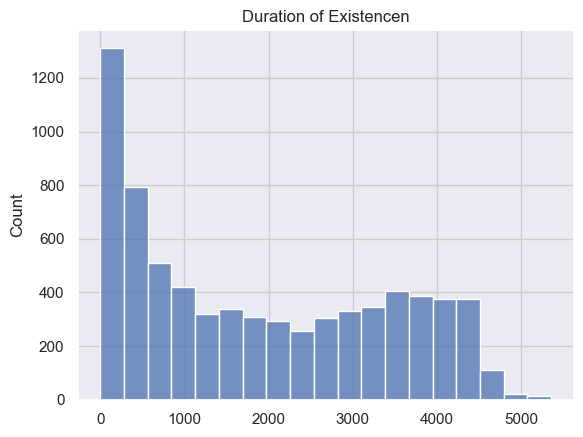

In [134]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.histplot(data=df_train_accounts, x='user_age_max', palette=['blue'])

# Customise some display properties
ax.set_title('Duration of Existencen')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
#ax.set_xticklabels(last_tweets["duration_bf_suspension"].unique().astype(str), rotation='vertical', fontsize=8)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'duration_of_existence.png', bbox_inches='tight')
plt.show()

### Dormancy calculation (time between account creation and first post)

In [137]:
first_tweets = df_train.groupby(
   ['user_id', 'screen_name', 'account_created_at'], as_index=False
).agg(
    {
         'created_at': 'max'
    }
)

first_tweets['created_at'] = first_tweets['created_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
first_tweets['account_created_at'] = first_tweets['account_created_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
first_tweets['created_at_dmy'] = first_tweets['created_at'].apply(lambda x:datetime.datetime.strftime(x, '%b %d %Y')).tolist()
first_tweets.head(6)

,user_id,screen_name,account_created_at,created_at,created_at_dmy
0,59173,jorgebarahona,2006-12-11 21:58:49,2021-08-15 13:32:05,Aug 15 2021
1,76183,SarahTitterton,2006-12-17 18:29:14,2021-08-11 10:40:37,Aug 11 2021
2,798329,tansunit,2007-02-27 10:24:31,2021-08-15 20:31:32,Aug 15 2021
3,3510781,szuazo,2007-04-05 07:30:48,2021-08-15 18:34:46,Aug 15 2021
4,5202411,kohsija,2007-04-19 04:07:17,2021-08-15 23:42:40,Aug 15 2021
5,5709522,mranti,2007-05-02 06:08:45,2021-08-11 10:47:55,Aug 11 2021


In [138]:
first_tweets['dormancy_bf'] = (first_tweets['created_at']-first_tweets['account_created_at']).dt.days

In [142]:
first_tweets['week_dormancy'] = (first_tweets['dormancy_bf'] >= 7)
P = first_tweets.groupby(['week_dormancy'])['user_id'].count().reset_index()
P = P.rename(columns = {'user_id':'Count'})
P['Proportion'] = P['Count']/sum(P['Count'])
P

,week_dormancy,Count,Proportion
0,False,91,0.012604
1,True,7129,0.987396


# Number of Tweets

In [143]:
P = df_train.groupby(
   ['user_id', 'screen_name'], as_index=False
).agg(
    {
         'status_id': 'count'
    }
)

P.to_csv(results_bucket+'suso_tweet_vol.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,user_id,screen_name,status_id
0,59173,jorgebarahona,1
1,76183,SarahTitterton,1
2,798329,tansunit,1
3,3510781,szuazo,1
4,5202411,kohsija,1
5,5709522,mranti,1


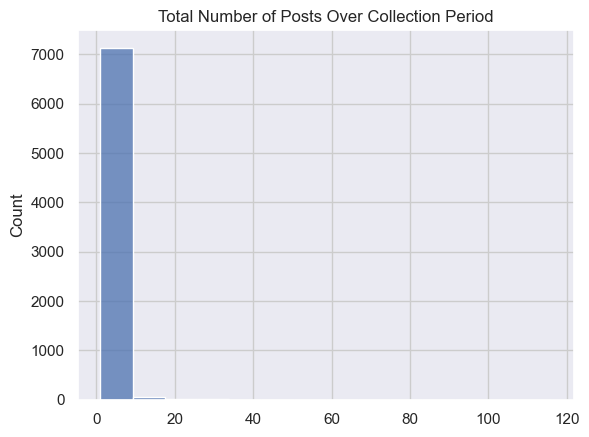

In [144]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.histplot(data=P, x='status_id', palette=['blue'])

# Customise some display properties
ax.set_title('Total Number of Posts Over Collection Period')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
#ax.set_xticklabels(df_train[df_train['suspended'] == 1]["id"].unique().astype(str), rotation='vertical', fontsize=6)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'suso_tweet_vol.png', bbox_inches='tight')
plt.show()

#### All Posts 

In [145]:
df_train_accounts['thousand_posts'] = (df_train_accounts['statuses_count_max'] >= 100)
P = df_train_accounts.groupby(['thousand_posts'])['user_id_'].count().reset_index()
P = P.rename(columns = {'user_id_':'Count'})
P['Proportion'] = P['Count']/sum(P['Count'])
P

,thousand_posts,Count,Proportion
0,False,338,0.046814
1,True,6882,0.953186


## Avg Tweet Rates

Aggregate Stats - mean

In [202]:
P = df_train_accounts.groupby(
   ['full_collapse'], as_index=False
).agg(
    {
         'avg_tweets_per_day_mean': 'mean'
    }
)

P.to_csv(results_bucket+'avg_tweets_per_day_svsns.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,full_collapse,avg_tweets_per_day_mean
0,1,1.197198


In [203]:
P = df_train_accounts.groupby(
   ['full_collapse'], as_index=False
).agg(
    {
         'avg_tweets_per_day_mean': 'max'
    }
)

P.to_csv(results_bucket+'max_avg_tweets_per_day_svsns.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,full_collapse,avg_tweets_per_day_mean
0,1,16.666667


Bin for Visuals

In [204]:
df_train_accounts['avg_tweets_per_day_bins'] = pd.cut(df_train_accounts['avg_tweets_per_day_mean'],bins = pd.interval_range(start=0, end= df_train_accounts['avg_tweets_per_day_mean'].max(), periods=50))

In [205]:
df_train_accounts['avg_tweets_per_day_bins'] = df_train_accounts['avg_tweets_per_day_bins'].apply(lambda x: pd.Interval(left=int(round(x.left)), right=int(round(x.right))))
df_train_accounts['avg_tweets_per_day_bins'] =df_train_accounts['avg_tweets_per_day_bins'].astype('str')

## Min amount of time between tweets

Aggregate Statitics - Mean

In [147]:
P = df_train_accounts.groupby(
   ['full_collapse'], as_index=False
).agg(
    {
         'since_last_tweet_mins_mean': 'mean'
    }
)

P.to_csv(results_bucket+'since_last_tweet_mins_min_mean_svsns.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,full_collapse,since_last_tweet_mins_mean
0,1,390.104512


Aggregate Statistics - Number of less than a minute average

In [148]:
df_train_accounts['fast_tweeting'] = (df_train_accounts['since_last_tweet_mins_min'] < 1)
P = df_train_accounts.groupby(['full_collapse', 'fast_tweeting'])['user_id_'].count().reset_index()
P = P.rename(columns = {'full_collapse':'All', 'user_id_':'Count'})
P['Total_sus'] = P.groupby('All')['Count'].transform('sum')
P['Proportion'] = P['Count']/P['Total_sus']
P

,All,fast_tweeting,Count,Total_sus,Proportion
0,1,False,6891,7220,0.954432
1,1,True,329,7220,0.045568


## Avg Tweet Rates for Retweets Only

In [150]:
df_train['is_reply'] = (df_train['reply_to_screen_name'].fillna(False) != False).astype(int)

df_train_accounts_retweets = df_train[df_train['is_reply'] == 1].groupby(
   ['user_id', 'screen_name'], as_index=False
).agg(
    {
         'status_id': 'count', 
         'tweets_per_day': 'max',  
         'since_last_tweet_mins_min': 'mean',  
         'since_last_tweet_mins_max': 'mean',  
         'since_last_tweet_mins_mean': 'mean',  
         'avg_tweets_per_hr': 'mean',  
         'avg_tweets_per_day': 'mean',  
         'is_reply': 'sum',
    }
)
df_train_accounts_retweets.head(3)

,user_id,screen_name,status_id,tweets_per_day,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,is_reply
0,11191362,traveler908,1,2.278067,NaN,NaN,NaN,1.0,1.0,1
1,14653970,jerrylovesleica,3,0.150877,4.066667,102.183333,53.125,1.5,3.0,3
2,15409017,LxGnzlz,1,2.655995,NaN,NaN,NaN,1.0,1.0,1


In [152]:
df_train_accounts_retweets['full_collapse'] = 1
P = df_train_accounts_retweets.groupby(
   ['full_collapse'], as_index=False
).agg(
    {
         'avg_tweets_per_day': 'mean'
    }
)

P.to_csv(results_bucket+'retweets_avg_tweets_per_day_svsns.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,full_collapse,avg_tweets_per_day
0,1,1.386645


In [153]:
P = df_train_accounts_retweets.groupby(
   ['full_collapse'], as_index=False
).agg(
    {
         'avg_tweets_per_day': 'max'
    }
)

P.to_csv(results_bucket+'retweets_max_tweets_per_day_svsns.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,full_collapse,avg_tweets_per_day
0,1,16.666667


In [154]:
df_train_accounts_retweets['avg_tweets_per_day_bins'] = pd.cut(df_train_accounts_retweets['avg_tweets_per_day'],bins = pd.interval_range(start=0, end= df_train_accounts['avg_tweets_per_day_mean'].max(), periods=50))

In [155]:
df_train_accounts_retweets['avg_tweets_per_day_bins'] = df_train_accounts_retweets['avg_tweets_per_day_bins'].apply(lambda x: pd.Interval(left=int(round(x.left)), right=int(round(x.right))))
df_train_accounts_retweets['avg_tweets_per_day_bins'] = df_train_accounts_retweets['avg_tweets_per_day_bins'].astype('str')

In [156]:
P = df_train_accounts_retweets.groupby(['avg_tweets_per_day_bins','full_collapse'], as_index=False).agg({"user_id": "count"})
P = P.rename(columns = {'avg_tweets_per_day_bins':'TweetRates','full_collapse':'Full', 'user_id':'Count'})
P.head()

,TweetRates,Full,Count
0,"(1, 1]",1,1056
1,"(1, 2]",1,54
2,"(10, 10]",1,1
3,"(11, 12]",1,1
4,"(12, 13]",1,1


## Follower Counts

In [157]:
df_train.sort_values(by=['user_id', 'created_at'], inplace=True)

# for this example, with diff, I think this syntax is a bit clunky
# but for more general examples, this should be good.  But can we do better?
df_train['follower_diffs'] = df_train.groupby(['user_id'])['followers_count'].transform(lambda x: x.diff()) 

df_train.sort_index(inplace=True)

In [158]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%B-%Y') #This is a format. Will be clear in Screenshot

#### Max Followers Change Per Day

In [159]:
df_train['created_at'] = df_train['created_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df_train['created_at_dmy'] = df_train['created_at'].apply(lambda x:datetime.datetime.strftime(x, '%b %d %Y')).tolist()

In [161]:
df_train['full_collapse'] = 1

In [163]:
P = df_train.groupby(['created_at_dmy','full_collapse'], as_index=False).agg({"follower_diffs": "mean"})
P = P.rename(columns = {'created_at_dmy':'Date','full_collapse':'Full', 'follower_diffs':'Count'})
P['Date'] = pd.to_datetime(P['Date'], infer_datetime_format=True).dt.date
P = P.sort_values(by=['Count'], ascending = False)
P.head()

,Date,Full,Count
6,2021-08-15,1,0.001588
0,2021-08-09,1,0.000000
1,2021-08-10,1,0.000000
2,2021-08-11,1,0.000000
3,2021-08-12,1,0.000000


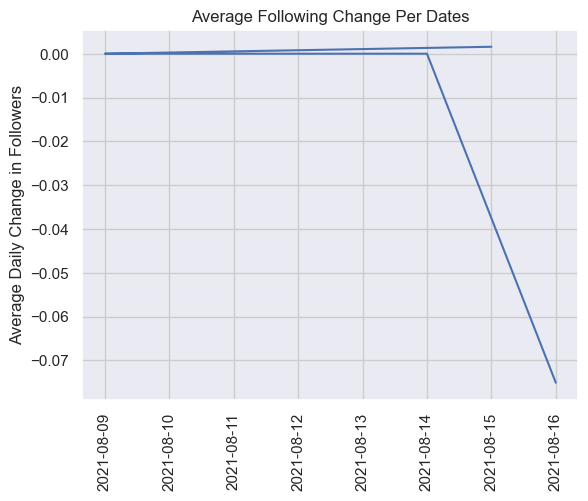

In [164]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.lineplot(data=P, x="Date", y="Count", sort=False)

# Customise some display properties
ax.set_title('Average Following Change Per Dates')
ax.grid(color='#cccccc')
ax.set_ylabel('Average Daily Change in Followers')
ax.set_xlabel(None)
plt.xticks(rotation='vertical')

plt.savefig(results_bucket+'followers_count_change_daily_susvsns.png', bbox_inches='tight')
# Ask Matplotlib to show it
plt.show()

#### Max followers 

In [165]:
P2 = df_train.groupby(['full_collapse'], as_index=False).agg({"followers_count": "max"})
P2 = P2.rename(columns = {'full_collapse':'Full', 'followers_count':'Count'})
P2.head()

,Full,Count
0,1,13495030.0


Max Followers Jump

In [166]:
P2 = df_train.groupby(['full_collapse'], as_index=False).agg({"follower_diffs": "max"})
P2 = P2.rename(columns = {'full_collapse':'Full', 'follower_diffs':'Count'})
P2.head()

,Full,Count
0,1,2.0


In [167]:
t = df_train[df_train['follower_diffs'] == P2['Count'].iloc[0]]
t = t[['screen_name', 'created_at', 'text', 'followers_count', 'followers_countdailychange', 'follower_diffs']].sort_values(by=['created_at'], ascending=True)
t

,screen_name,created_at,text,followers_count,followers_countdailychange,follower_diffs
883,Ahmad_sayss,2021-08-15 23:47:44,Afghan girls on their way to school today morn...,1082.0,2.0,2.0
424,asimkhan771,2021-08-16 00:34:33,Afghan girls on their way to school today morn...,1423.0,1.0,2.0


#### Zero Followers comparison

In [171]:
df_train_accounts['zero_foll'] = (df_train_accounts['followers_count_max'] == 0)
P = df_train_accounts.groupby(['full_collapse', 'zero_foll'])['user_id_'].count().reset_index()
P = P.rename(columns = {'full_collapse':'Full', 'user_id_':'Count'})
P['Total_sus'] = P.groupby('Full')['Count'].transform('sum')
P['Proportion'] = P['Count']/P['Total_sus']
P

,Full,zero_foll,Count,Total_sus,Proportion
0,1,False,7108,7220,0.984488
1,1,True,112,7220,0.015512


#### Follower Daily Jumps 

Histograms of Follower rate jumps

Max

In [185]:
P1 = df_train.groupby(
   ['user_id', 'screen_name'], as_index=False
).agg(
    {
         'followers_countdailychange': 'max'
    }
).dropna(subset=['followers_countdailychange']).sort_values(by=['followers_countdailychange'], ascending=False)

P1['followers_countdailychange'] = P1['followers_countdailychange'].round().astype('int')

P1.to_csv(results_bucket+'susp_max_follower_count_dailychange.csv', index=False, encoding = "utf_8_sig")
P1.head(6)

,user_id,screen_name,followers_countdailychange
1459,434861621,Ahmad_sayss,2
508,102753335,tomthehack,1
2752,2912966501,masif9593,1
3365,760111691560615936,asimkhan771,1
7,6278942,dlcmh,0
5246,1240913962008485888,Shamila62639453,0


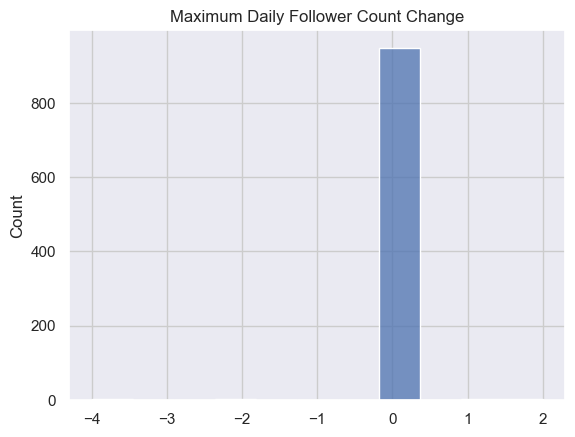

In [186]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.histplot(data=P1, x='followers_countdailychange', palette=['blue'])

# Customise some display properties
ax.set_title('Maximum Daily Follower Count Change')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'suspended_max_followers_count_change_daily.png', bbox_inches='tight')
plt.show()

## Friend Counts

In [187]:
df_train.sort_values(by=['user_id', 'created_at'], inplace=True)

# for this example, with diff, I think this syntax is a bit clunky
# but for more general examples, this should be good.  But can we do better?
df_train['friend_diffs'] = df_train.groupby(['user_id'])['friends_count'].transform(lambda x: x.diff()) 

df_train.sort_index(inplace=True)

In [188]:
P = df_train_accounts.groupby(['full_collapse'], as_index=False).agg({"friends_count_max": ["mean", "std"]})
P.head()

full_collapse friends_count_max             
                             mean          std
0             1       1237.928393  3949.857561

In [177]:
P = df_train.groupby(['created_at_dmy','full_collapse'], as_index=False).agg({"friend_diffs": "mean"})
P = P.rename(columns = {'created_at_dmy':'Date','full_collapse':'Full', 'friend_diffs':'Count'})
P['Date'] = pd.to_datetime(P['Date'], infer_datetime_format=True).dt.date
P = P.sort_values(by=['Count'], ascending=False)
P.head()

,Date,Full,Count
7,2021-08-16,1,0.023474
6,2021-08-15,1,0.001985
0,2021-08-09,1,0.000000
1,2021-08-10,1,0.000000
2,2021-08-11,1,0.000000


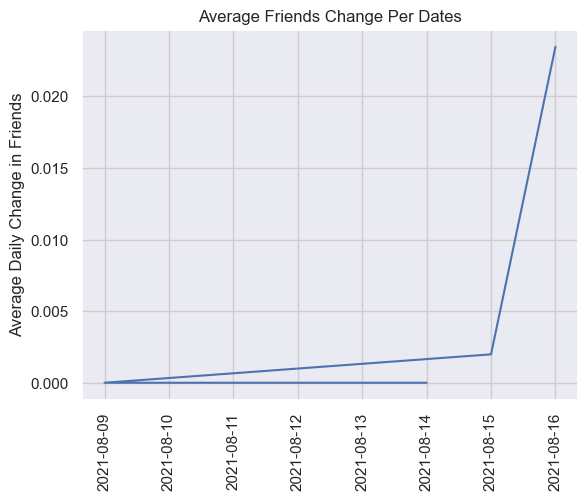

In [178]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.lineplot(data=P, x="Date", y="Count", sort=False)

# Customise some display properties
ax.set_title('Average Friends Change Per Dates')
ax.grid(color='#cccccc')
ax.set_ylabel('Average Daily Change in Friends')
ax.set_xlabel(None)
plt.xticks(rotation='vertical')

plt.savefig(results_bucket+'friends_count_change_daily_susvsns.png', bbox_inches='tight')
# Ask Matplotlib to show it
plt.show()

#### Max Friends

In [180]:
P2 = df_train.groupby(['full_collapse'], as_index=False).agg({"friend_diffs": "max"})
P2 = P2.rename(columns = {'full_collapse':'Full', 'friend_diffs':'Count'})
P2.head()

,Full,Count
0,1,2.0


In [181]:
t = df_train[df_train['friend_diffs'] == P2['Count'].iloc[0]]
t = t[['screen_name', 'created_at', 'text', 'friends_count', 'friends_countdailychange', 'friend_diffs']].sort_values(by=['created_at'], ascending=True)
t

,screen_name,created_at,text,friends_count,friends_countdailychange,friend_diffs
1357,Reddit_Bharat,2021-08-15 23:04:40,"The first day of Taliban rule in #Kabul, brave...",408.0,2.0,2.0
424,asimkhan771,2021-08-16 00:34:33,Afghan girls on their way to school today morn...,1026.0,1.0,2.0
108,FarazA141,2021-08-16 00:53:32,"The first day of Taliban rule in #Kabul, brave...",1263.0,2.0,2.0


#### Zero Friends comparison

In [183]:
df_train_accounts['zero_friend'] = (df_train_accounts['friends_count_max'] == 0)
P = df_train_accounts.groupby(['full_collapse', 'zero_friend'])['user_id_'].count().reset_index()
P = P.rename(columns = {'full_collapse':'Full', 'user_id_':'Count'})
P['Total_sus'] = P.groupby('Full')['Count'].transform('sum')
P['Proportion'] = P['Count']/P['Total_sus']
P

,Full,zero_friend,Count,Total_sus,Proportion
0,1,False,7177,7220,0.994044
1,1,True,43,7220,0.005956


#### Max Daily Friends Increase Range of Acounts

In [190]:
P1 = df_train.groupby(
   ['user_id', 'screen_name'], as_index=False
).agg(
    {
         'friends_countdailychange': 'max'
    }
).dropna(subset=['friends_countdailychange']).sort_values(by=['friends_countdailychange'], ascending=False)

P1['friends_countdailychange'] = P1['friends_countdailychange'].round().astype('int')

P1.to_csv(results_bucket+'susp_max_friend_count_dailychange.csv', index=False, encoding = "utf_8_sig")
P1.head(6)

,user_id,screen_name,friends_countdailychange
6195,1355442449099833344,Reddit_Bharat,2
5753,1302460142013747201,FarazA141,2
2677,2785609565,EngiNeerChUmair,1
1459,434861621,Ahmad_sayss,1
1333,369113790,2elevenz,1
3365,760111691560615936,asimkhan771,1


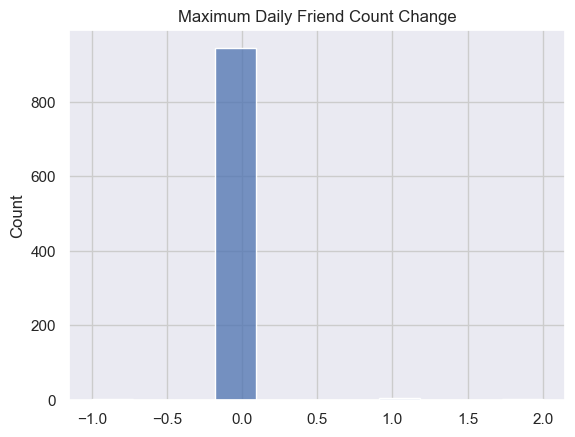

In [191]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.histplot(data=P1, x='friends_countdailychange', palette=['blue'])

# Customise some display properties
ax.set_title('Maximum Daily Friend Count Change')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'suspended_max_friends_count_change_daily.png', bbox_inches='tight')
plt.show()

#### Followers/Friends Ratio Calculation

In [192]:
P = df_train_accounts.replace([np.inf, 0], np.nan).groupby(
   ['full_collapse'], as_index=False
).agg(
    {
         'followers_per_followees_mean': ['mean', 'std'] 
    }
)

P.to_csv(results_bucket+'followers_per_followee.csv', index=False, encoding = "utf_8_sig")
P

full_collapse followers_per_followees_mean             
                                        mean          std
0             1                    82.190869  3238.034215

In [193]:
df_train_accounts['inf_ratio'] = (np.isinf(df_train_accounts['followers_per_followees_mean']))

In [194]:
P = df_train_accounts.groupby(['full_collapse', 'inf_ratio'])['user_id_'].count().reset_index()
P = P.rename(columns = {'full_collapse':'Full', 'user_id_':'Count'})
P['Total_sus'] = P.groupby('Full')['Count'].transform('sum')
P['Proportion'] = P['Count']/P['Total_sus']
P

,Full,inf_ratio,Count,Total_sus,Proportion
0,1,False,7187,7220,0.995429
1,1,True,33,7220,0.004571


## Hashtag Analysis 

Not Suspended

In [195]:
P = df_train.text.str.extractall(r'(\#\w+)')[0].value_counts().rename_axis('hashtag').reset_index(name='counts')
P.head(10)

,hashtag,counts
0,#Kabul,1722
1,#Afghanistan,1276
2,#Taliban,877
3,#GTCartoon,512
4,#US,470
5,#Afghan,382
6,#Dasu,282
7,#Indian,273
8,#Pakistani,272
9,#Opinion,265


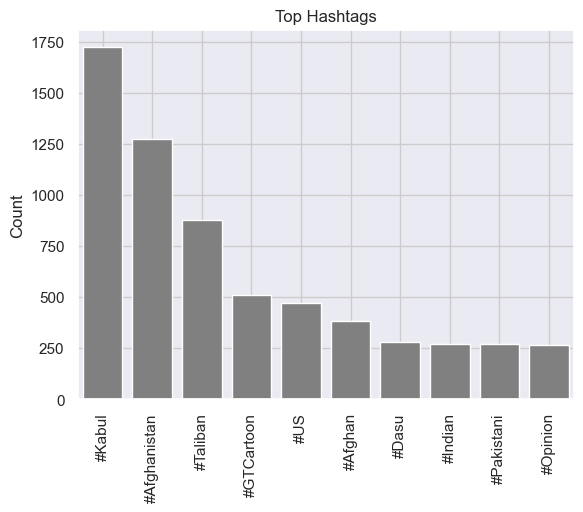

In [196]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.barplot(data=P[:10], x="hashtag", y="counts", palette=['blue'], saturation=0)

# Customise some display properties
ax.set_title('Top Hashtags')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
ax.set_xticklabels(P[:10]["hashtag"].unique().astype(str), rotation='vertical')

# Ask Matplotlib to show it
plt.savefig(results_bucket+'top_hashtags_non_suspended accounts.png', bbox_inches='tight')
plt.show()

## Account Mentions Analysis

In [197]:
P = df_train.text.str.extractall(r'@([A-Za-z0-9_]+)')[0].value_counts().rename_axis('mention').reset_index(name='counts')
P.head(10)

,mention,counts
0,globaltimesnews,918
1,jawidomid,848
2,MFA_China,454
3,zlj517,296
4,CGTNOfficial,288
5,POTUS,243
6,chenweihua,194
7,SecBlinken,190
8,XHNews,187
9,mfa_russia,177


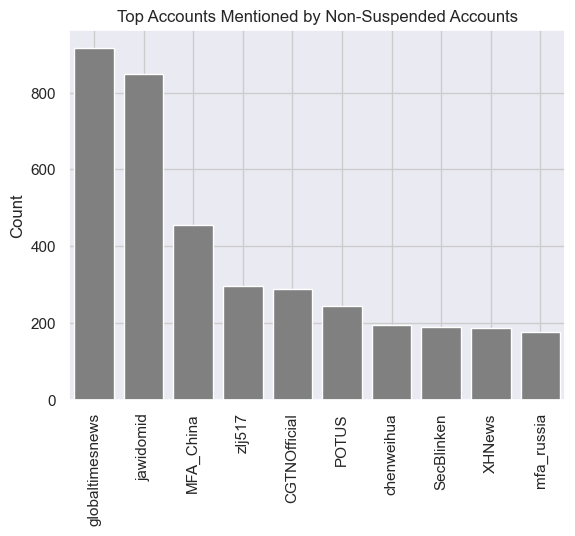

In [200]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.barplot(data=P[:10], x="mention", y="counts", palette=['blue'], saturation=0)

# Customise some display properties
ax.set_title('Top Accounts Mentioned by Non-Suspended Accounts')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
ax.set_xticklabels(P[:10]["mention"].unique().astype(str), rotation='vertical')

# Ask Matplotlib to show it
plt.savefig(results_bucket+'non_suspended_accounts_mentions.png', bbox_inches='tight')
plt.show()

#### Number of Mentions, Hashtags, and URLs per 

In [201]:
P = df_train_accounts.groupby(
   ['full_collapse'], as_index=False
).agg(
    { 
         'no_urls_per_tweet_mean': 'mean', 
         'no_hashtags_per_tweet_mean': 'mean',
         'no_mentions_per_tweet_mean': 'mean',
    }
)
P['no_urls_per_tweet_mean'] = (P['no_urls_per_tweet_mean'] * 100).round(2)
P['no_hashtags_per_tweet_mean'] = (P['no_hashtags_per_tweet_mean'] * 100).round(2)
P['no_mentions_per_tweet_mean'] = (P['no_mentions_per_tweet_mean'] * 100).round(2)

P = P.rename(columns = {'full_collapse':'Full','no_urls_per_tweet_mean':'Average URLs Per Tweet', 
                        'no_hashtags_per_tweet_mean':'Average Hashtag Per Tweet', 'no_mentions_per_tweet_mean':'Average Mentions Per Tweet'})

P.to_csv(results_bucket+'url_hashtag_mentions_diff.csv', index=False, encoding = "utf_8_sig")
P

,Full,Average URLs Per Tweet,Average Hashtag Per Tweet,Average Mentions Per Tweet
0,1,82.77,94.41,95.74
